In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.7 MB/s eta 0:00:00


E vs S

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3571 - loss: 3077.8794 - val_accuracy: 0.6667 - val_loss: nan
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accurac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Evaluation Metrics:
Test Accuracy:  0.6666666666666666
Test Recall (Weighted):  0.6666666666666666
Test Precision (Weighted):  0.4444444444444444
Test F1 Score (Weighted):  0.5333333333333333
Confusion Matrix: 
 [[4 0]
 [2 0]]
Training Duration (in seconds):  95.2789659500122


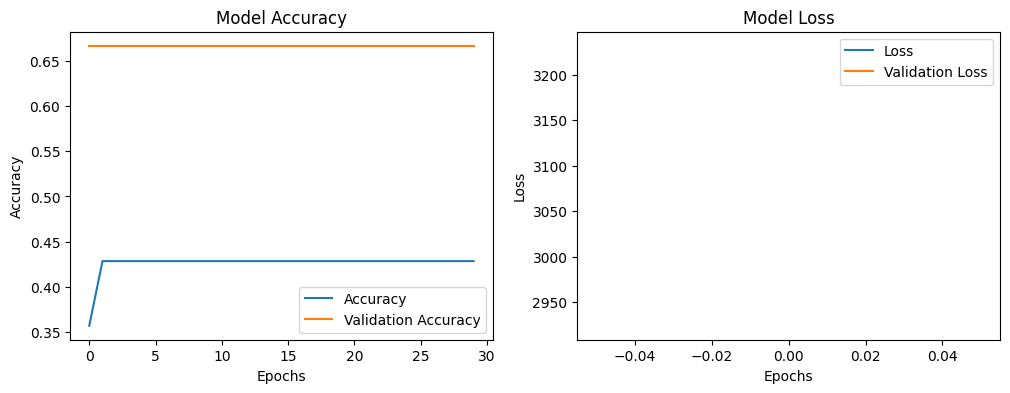

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp2/No_Options.keras ✅


In [3]:
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# Function to load data (only a subset of files for testing)
def load_data(directory_path, label, num_files=10):  # Add a num_files parameter to limit the number of files
    data = []
    labels = []
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]
    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files[:num_files]:  # Only load the first `num_files`
        file_path = os.path.join(directory_path, filename)
        try:
            signal = np.loadtxt(file_path)
            data.append(signal)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concatenate all coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Paths to your datasets
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data with wavelet decomposition
data_Epileptic, labels_Epileptic = load_data(path_Epileptic, label=0)
data_Seizure, labels_Seizure = load_data(path_Seizure, label=1)

# Combine data and labels
if data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()
    training_duration = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

      # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp2/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


with stander

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5714 - loss: 0.6500 - val_accuracy: 0.3333 - val_loss: 0.6916
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5714 - loss: 0.5686 - val_accuracy: 0.3333 - val_loss: 0.7881
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5714 - loss: 0.5467 - val_accuracy: 0.1667 - val_loss: 77723056.0000
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3571 - loss: 386415495773784119879663616.0000 - val_accuracy: 0.6667 - val_loss: nan
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 9/30
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


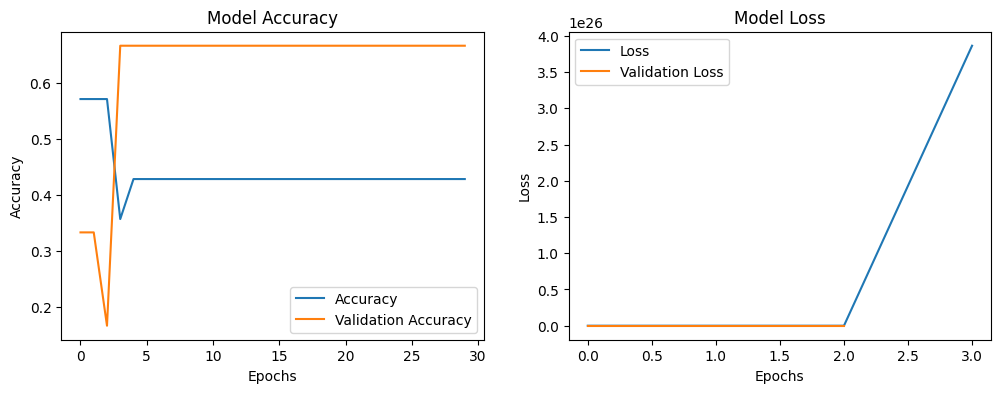

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp2/With_Stander.keras ✅


In [4]:
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# Function to load data (only a subset of files for testing)
def load_data(directory_path, label, num_files=10):  # Add a num_files parameter to limit the number of files
    data = []
    labels = []
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]
    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files[:num_files]:  # Only load the first `num_files`
        file_path = os.path.join(directory_path, filename)
        try:
            signal = np.loadtxt(file_path)
            data.append(signal)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concatenate all coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Paths to your datasets
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data with wavelet decomposition
data_Epileptic, labels_Epileptic = load_data(path_Epileptic, label=0)
data_Seizure, labels_Seizure = load_data(path_Seizure, label=1)

# Combine data and labels
if data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all)

    # Scale the data using StandardScaler
    scaler = StandardScaler()
    data_all_scaled = scaler.fit_transform(data_all)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_scaled, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()
    training_duration = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



    # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp2/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


With Optimiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4286 - loss: 336252480.0000 - val_accuracy: 0.6667 - val_loss: nan
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.6667 - val_loss: nan
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.428

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


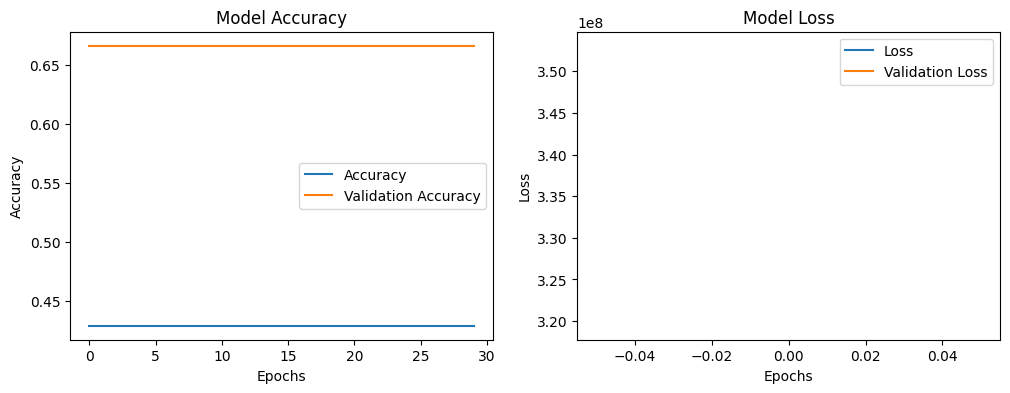

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp2/With_Optimiser.keras ✅


In [5]:
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from tensorflow.keras.optimizers import Adam
import time

# Function to load data (only a subset of files for testing)
def load_data(directory_path, label, num_files=10):  # Add a num_files parameter to limit the number of files
    data = []
    labels = []
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]
    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files[:num_files]:  # Only load the first `num_files`
        file_path = os.path.join(directory_path, filename)
        try:
            signal = np.loadtxt(file_path)
            data.append(signal)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concatenate all coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Paths to your datasets
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data with wavelet decomposition
data_Epileptic, labels_Epileptic = load_data(path_Epileptic, label=0)
data_Seizure, labels_Seizure = load_data(path_Seizure, label=1)

# Combine data and labels
if data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])

    # Compile the model using the Adam optimizer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()
    training_duration = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")




     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp2/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")

with both

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5714 - loss: 0.6565 - val_accuracy: 0.3333 - val_loss: 0.6712
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5714 - loss: 0.6115 - val_accuracy: 0.3333 - val_loss: 0.6835
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5714 - loss: 0.5910 - val_accuracy: 0.3333 - val_loss: 0.7132
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5714 - loss: 0.5664 - val_accuracy: 0.3333 - val_loss: 0.7671
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5714 - loss: 0.5461 - val_accuracy: 0.3333 - val_loss: 0.8593
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5714 - loss: 0.5072 - val_accuracy: 0.3333 - val_loss: 0.9826
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5714 - loss: 0.5111 - val_accuracy: 0.3333 - val_loss: 1.1774
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5714 - loss: 0.4746 - val_accuracy: 0.3333 - val_loss: 1.1819
Epoch 9/30
1/1 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


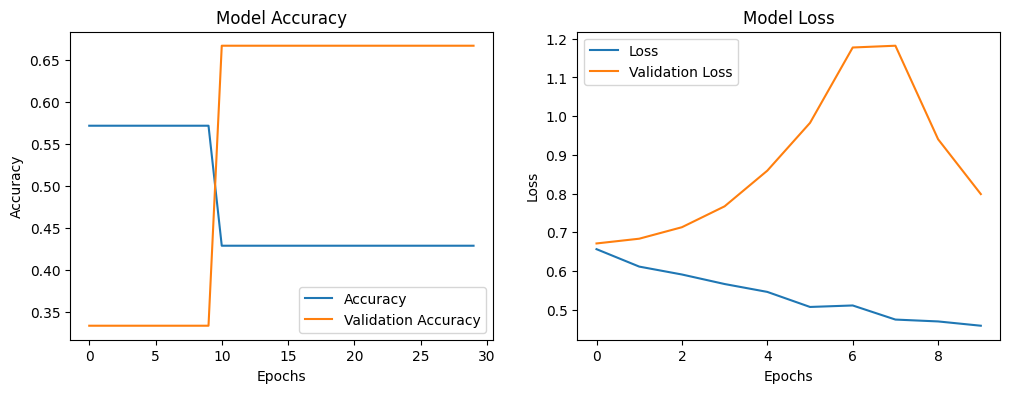

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp2/With_Options.keras ✅


In [6]:
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from tensorflow.keras.optimizers import Adam
import time

# Function to load data (only a subset of files for testing)
def load_data(directory_path, label, num_files=10):  # Add a num_files parameter to limit the number of files
    data = []
    labels = []
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]
    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files[:num_files]:  # Only load the first `num_files`
        file_path = os.path.join(directory_path, filename)
        try:
            signal = np.loadtxt(file_path)
            data.append(signal)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concatenate all coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Paths to your datasets
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data with wavelet decomposition
data_Epileptic, labels_Epileptic = load_data(path_Epileptic, label=0)
data_Seizure, labels_Seizure = load_data(path_Seizure, label=1)

# Combine data and labels
if data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all)

    # Scale the data using StandardScaler
    scaler = StandardScaler()
    data_all_scaled = scaler.fit_transform(data_all)

    # Convert labels to one-hot encoding
    labels_all_one_hot = to_categorical(labels_all, num_classes=2)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_scaled, labels_all_one_hot, test_size=0.3, random_state=42)

    # Reshape to 3D for CNN-LSTM input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])

    # Compile the model using the Adam optimizer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()
    training_duration = end_time - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



        # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp2/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")
